# Extra material: Refinery production and shadow pricing

This is a simple linear programming problem in six variables, but with four equality constraints it allows for a graphical explanation of some unusually large shadow prices for manufacturing capacity. The notebook presents also contrasts Pyomo with CVXPY modeling.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

This example derived from Example 19.3 from Seborg, Edgar, Mellichamp, and Doyle. The changes include updating prices, new solutions using optimization modeling languages, adding constraints, and adjusting parameter values to demonstrate the significance of duals and their interpretation as shadow prices.

## Problem data

In [2]:
import pandas as pd

products = pd.DataFrame({
    "gasoline": {"capacity": 24000, "price": 108},
    "kerosine": {"capacity":  2000, "price": 72},
    "fuel oil": {"capacity":  6000, "price": 63},
    "residual": {"capacity":  2500, "price": 30},
}).T

crudes = pd.DataFrame({
    "crude 1": {"available": 28000, "price": 72, "process cost": 1.5},
    "crude 2": {"available": 15000, "price": 45, "process cost": 3},
}).T

# note: volumetric yields may not add to 100%
yields = pd.DataFrame({
    "crude 1": {"gasoline": 80, "kerosine": 5, "fuel oil": 10, "residual": 5},
    "crude 2": {"gasoline": 44, "kerosine": 10, "fuel oil": 36, "residual": 10},
}).T

display(products)
display(crudes)
display(yields)

,capacity,price
gasoline,24000,108
kerosine,2000,72
fuel oil,6000,63
residual,2500,30


,available,price,process cost
crude 1,28000.0,72.0,1.5
crude 2,15000.0,45.0,3.0


,gasoline,kerosine,fuel oil,residual
crude 1,80,5,10,5
crude 2,44,10,36,10


## Pyomo Model

In [3]:
import pyomo.environ as pyo

m = pyo.ConcreteModel()

m.CRUDES = pyo.Set(initialize=crudes.index)
m.PRODUCTS = pyo.Set(initialize=products.index)

# decision variables
m.x = pyo.Var(m.CRUDES, domain=pyo.NonNegativeReals)
m.y = pyo.Var(m.PRODUCTS, domain=pyo.NonNegativeReals)

# objective
@m.Expression()
def revenue(m):
    return sum(products.loc[p, "price"] * m.y[p] for p in m.PRODUCTS)

@m.Expression()
def feed_cost(m):
    return sum(crudes.loc[c, "price"] * m.x[c] for c in m.CRUDES)

@m.Expression()
def process_cost(m):
    return sum(crudes.loc[c, "process cost"] * m.x[c] for c in m.CRUDES)

@m.Objective(sense=pyo.maximize)
def profit(m):
    return m.revenue - m.feed_cost - m.process_cost

# constraints
@m.Constraint(m.PRODUCTS)
def balances(m, p):
    return m.y[p] == sum(yields.loc[c, p] * m.x[c] for c in m.CRUDES)/100

@m.Constraint(m.CRUDES)
def feeds(m, c):
    return m.x[c] <= crudes.loc[c, "available"]

@m.Constraint(m.PRODUCTS)
def capacity(m, p):
    return m.y[p] <= products.loc[p, "capacity"]

# solution
pyo.SolverFactory('glpk').solve(m)
print(m.profit())


860275.8620689679


## CVXPY Model

The `CVXPY` library for disciplined convex programming is tightly integrated with `numpy`, the standard Python library for the numerical linear algebra. For example, where `Pyomo` uses explicit indexing in constraints, summations, and other objects, `CVXPY` uses the implicit indexing implied when doing matrix and vector operations. 

Another sharp contrast with `Pyomo` is that `CXVPY` has no specific object to describe a set,or to define a objects variables or other modeling objects over arbitrary sets. `CVXPY` insteady uses the zero-based indexing familiar to Python users. 

The following cell demonstrates these differences by presenting a `CVXPY` model for the small refinery example. 

In [4]:
import numpy as np
import cvxpy as cp

# decision variables
x = cp.Variable(len(crudes.index), pos=True, name="crudes")
y = cp.Variable(len(products.index), pos=True, name="products")

# objective
revenue = products["price"].to_numpy().T @ y
feed_cost = crudes["price"].to_numpy().T @ x
process_cost = crudes["process cost"].to_numpy().T @ x
profit = revenue - feed_cost - process_cost
objective = cp.Maximize(profit)

# constraints
balances = y == yields.to_numpy().T @ x/100
feeds = x <= crudes["available"].to_numpy()
capacity = y <= products["capacity"].to_numpy()
constraints = [balances, feeds, capacity]

# solution
problem = cp.Problem(objective, constraints)
problem.solve()


860275.861556892

## Crude oil feed results

In [5]:
results_crudes = crudes
results_crudes["consumption"] = x.value
results_crudes["shadow price"] = feeds.dual_value

display(results_crudes.round(1))

,available,price,process cost,consumption,shadow price
crude 1,28000.0,72.0,1.5,26206.9,0.0
crude 2,15000.0,45.0,3.0,6896.6,0.0


## Refinery production results

In [6]:
results_products = products
results_products["production"] = y.value
results_products["unused capacity"] = products["capacity"] - y.value
results_products["shadow price"] = capacity.dual_value

display(results_products.round(1))

,capacity,price,production,unused capacity,shadow price
gasoline,24000,108,24000.0,0.0,14.0
kerosine,2000,72,2000.0,0.0,262.6
fuel oil,6000,63,5103.4,896.6,0.0
residual,2500,30,2000.0,500.0,0.0


## Why is the shadow price of kerosine so high?

(0.0, 24000.0)

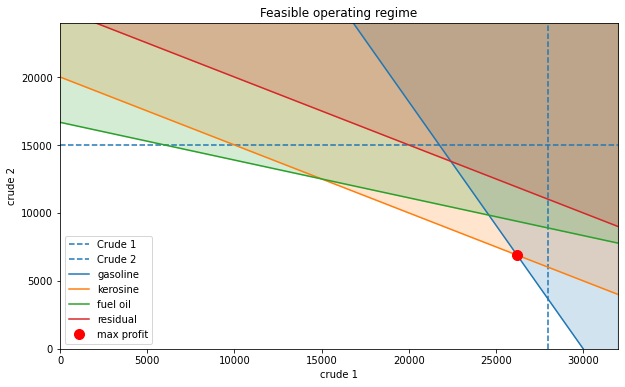

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
ylim = 24000
xlim = 32000

ax.axvline(crudes["available"][0], linestyle='--', label="Crude 1")
ax.axhline(crudes["available"][1], linestyle='--', label="Crude 2")

xplot = np.linspace(0, xlim)
for product in products.index:
    b = 100*products.loc[product, "capacity"]/yields[product][1]
    m = - yields[product][0]/yields[product][1]
    line = ax.plot(xplot, m*xplot + b, label=product)
    ax.fill_between(xplot, m*xplot + b, 30000, color=line[0].get_color(), alpha=0.2)

ax.plot(x.value[0], x.value[1], 'ro', ms=10, label="max profit")
ax.set_title("Feasible operating regime")
ax.set_xlabel(crudes.index[0])
ax.set_ylabel(crudes.index[1])
ax.legend()
ax.set_xlim(0, xlim)
ax.set_ylim(0, ylim)

## Suggested Exercises

1. Suppose the refinery makes a substantial investment to double kerosine production in order to increase profits. What becomes the limiting constraint?

2. How do prices of crudes and products change the location of the optimum operating point?

2. A refinery is a financial asset for the conversion of commodity crude oils into commodity hydrocarbons. What economic value can be assigned to owning the option to convert crude oils into other commodities?